<a href="https://colab.research.google.com/github/KomuravelliTharuni/Medical-Image-Diagnosis/blob/main/Medical_Image_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json API key
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be resized to 224x224
img_size = 224
batch_size = 32

train_path = "/content/Training"
test_path = "/content/Testing"

# For training: apply resizing, scaling (normalization), and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

# For testing: just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'  # Because we have 4 classes
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Input

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers (they already learned a lot)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # You can increase this to improve accuracy
    validation_data=test_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


179/179 ━━━━━━━━━━━━━━━━━━━━ 113s 555ms/step - accuracy: 0.5638 - loss: 1.3235 - val_accuracy: 0.8131 - val_loss: 0.5281
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 447ms/step - accuracy: 0.7690 - loss: 0.5734 - val_accuracy: 0.8070 - val_loss: 0.4682
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 449ms/step - accuracy: 0.7820 - loss: 0.5246 - val_accuracy: 0.8375 - val_loss: 0.4239
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 467ms/step - accuracy: 0.7716 - loss: 0.4982 - val_accuracy: 0.8482 - val_loss: 0.3716
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.7824 - loss: 0.4690 - val_accuracy: 0.8253 - val_loss: 0.4011
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - accuracy: 0.7945 - loss: 0.4841 - val_accuracy: 0.8452 - val_loss: 0.3380
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 466ms/step - accuracy: 0.7925 - loss: 0.4657 - val_accuracy: 0.8383 - val_loss: 0.3830
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 448ms/step - accuracy: 0.7961 - loss: 0.4649 - va

In [6]:
model.save("brain_tumor_model.h5")


In [7]:
from tensorflow.keras.models import load_model
model = load_model("brain_tumor_model.h5")


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [9]:
model = tf.keras.models.load_model("brain_tumor_model.h5")

# Load and preprocess an image (example: 224x224)
img_path = '/content/Testing/glioma/Te-glTr_0007.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


In [10]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name,
                         pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output,
                         model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get the gradients of the predicted class
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


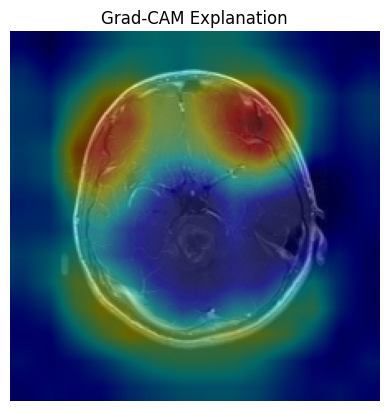

In [11]:
# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model,
                               last_conv_layer_name="block5_conv3")  # Change as per your model

# Load original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

# Apply heatmap
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Show
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM Explanation")
plt.show()


In [12]:
pip install gradio


In [ ]:
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("brain_tumor_model.h5")

# Class labels (must match training order)
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# 🔍 Helper: Find the last Conv2D layer automatically
def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model.")

# 🔥 Grad-CAM implementation
def get_gradcam(img_array, model, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 🧠 Gradio prediction function
def predict(image_input):
    # Resize and normalize image
    img = cv2.resize(image_input, (224, 224))
    img_array = np.expand_dims(img / 255.0, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Grad-CAM heatmap
    last_conv = get_last_conv_layer_name(model)
    heatmap = get_gradcam(img_array, model, last_conv)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay on original image
    original_resized = cv2.resize(image_input, (224, 224))
    overlay = cv2.addWeighted(original_resized, 0.6, heatmap, 0.4, 0)

    return predicted_class, overlay

# 🚀 Launch Gradio app
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=["label", "image"],
    title="🧠 Brain Tumor Classifier with Grad-CAM",
    description="Upload a brain MRI to detect tumor type and visualize Grad-CAM heatmap.",
)

interface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://33c9450a685bedd486.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
